In [39]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return math.sin(x / 5) * math.exp(x / 10) + 5 * math.exp(-x / 2)

In [3]:
X = np.arange(1, 15, 0.1)

In [4]:
y = [f(x) for x in X]

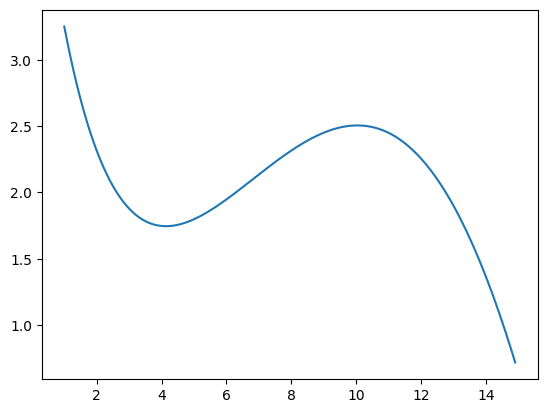

In [5]:
plt.plot(X, y)

In [6]:
a = 1.0
b = -15.0
c = 2.0

h = 0.0001
d1 = a*b + c
a = a + h
d2 = a*b + c

print(d1, d2)
print((d2 - d1) / h)

-13.0 -13.0015
-15.000000000000568


In [96]:
class Value:
    def __init__(self, data,_children=(), _op='', label = ''):
        self.data = data
        self.grad = 0
        # internal variables to keep track of the computation graph
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = _backward

        return out
    
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        
        return out

    def tanh(self):
        x = self.data
        o = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(o, (self,), 'tanh')
        def _backward():
            self.grad += (1 - o**2) * out.grad

        out._backward = _backward

        return out
    
    def exp(self):
        x= self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad+= math.exp(x) * out.grad
        
        out._backward = _backward

        return out

    

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
        
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __neg__(self): # -self
        return self.__mul__(-1)
    
    def __sub__(self, other): # self - other
        return self.__add__(-other)
    
    def __rmul__(self, other): # other*self
        return self.__mul__(other)
    
    def __radd__(self, other): # other+self
        return self.__add__(other)

    def __rtruediv__(self, other):
        return other * self**-1
     

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L


Value(data=-8.0)

In [ ]:
c

In [5]:
import graphviz

In [20]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f }" % (n.label,n.data,n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

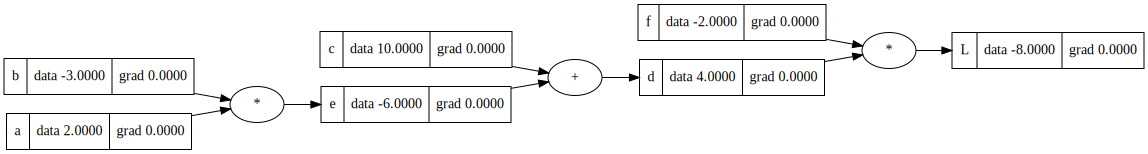

In [21]:
draw_dot(L)

In [34]:
def lol():
    h = 0.0001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    a.data = a.data + h
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1) / 0.0001)

lol()

6.000000000021544


In [35]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
e.grad = -2.0
c.grad = -2.0
b.grad = -4.0
a.grad = 6.0

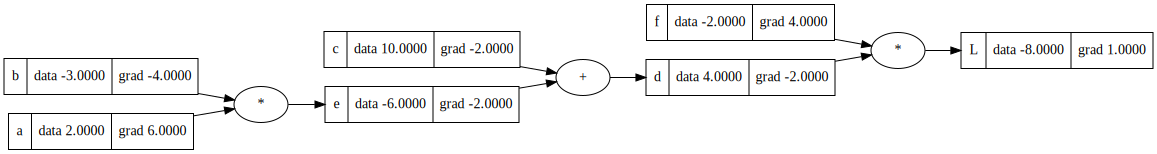

In [36]:
draw_dot(L)

In [37]:
a.data+= 0.001*a.grad
b.data+= 0.001*b.grad
c.data+= 0.001*c.grad
f.data+= 0.001*f.grad


e = a*b
d = e + c
L = d * f 
print(L.data)


-7.928064095999999


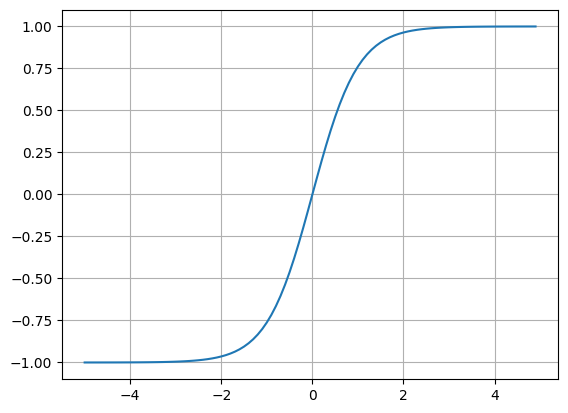

In [41]:
plt.plot(np.arange(-5, 5, 0.1), np.tanh(np.arange(-5, 5, 0.1))); plt.grid();

In [62]:
# inputs x1, x2
x1 = Value(1.0, label='x1')
x2 = Value(2.0, label='x2')

# weights w1, w2
w1 = Value(1.0, label='w1')
w2 = Value(-3.0, label='w2')

# bias
b = Value(1.0, label='b')

# x1*w1, x2*w2
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'



In [44]:
o.grad = 1.0
# dL/dn = dL/do * do/dn
n.grad = (1- o.data**2) * o.grad

In [46]:
x1w1x2w2.grad = n.grad
b.grad = n.grad
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

# dL/dx1 = dL/dx1w1 * dx1w1/dx1
x1.grad = x1w1.grad * w1.data
x2.grad = x2w2.grad * w2.data
w1.grad = x1w1.grad * x1.data
w2.grad = x2w2.grad * x2.data

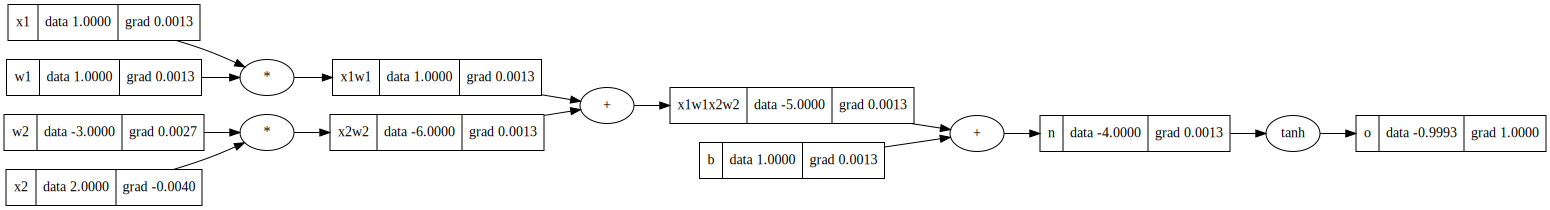

In [55]:
draw_dot(o)

In [52]:
# creating a topological order of the graph
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)


In [54]:
o.grad = 1.0
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

for node in reversed(topo):
    node._backward()

In [63]:
o.backward()

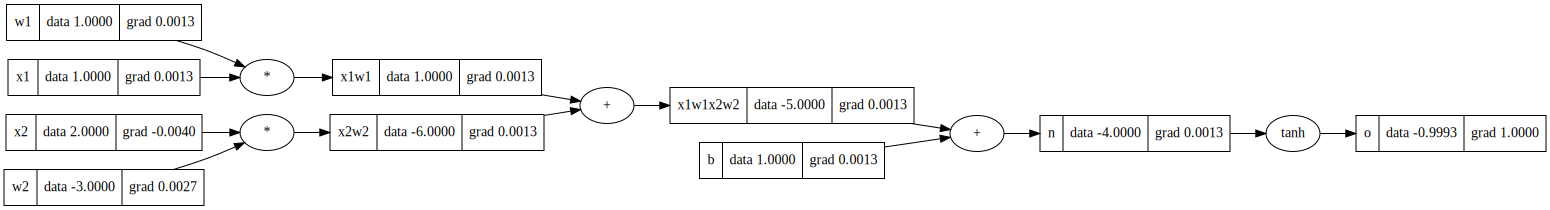

In [64]:
draw_dot(o)

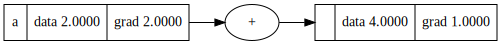

In [65]:
b= a + a
b.backward()
draw_dot(b)

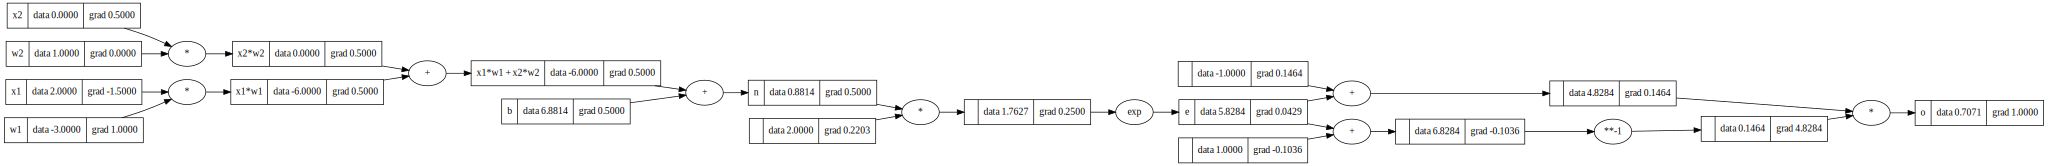

In [97]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

## implementing tanh with exp

e = (2*n).exp(); e.label = 'e'
o = (e - 1) / (e + 1); o.label = 'o'

o.backward()

draw_dot(o)

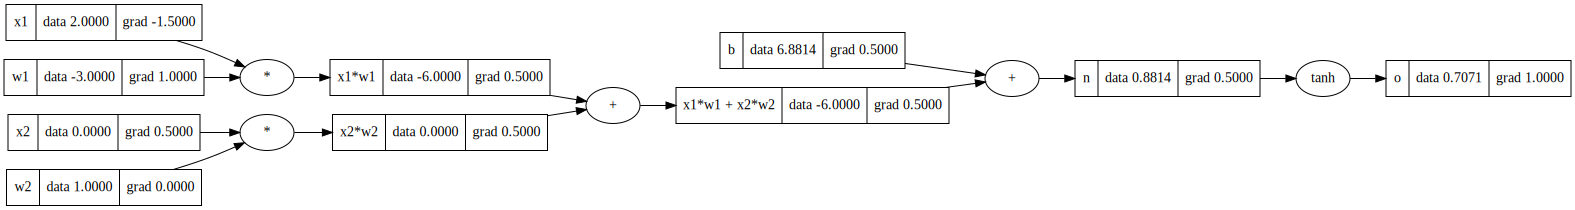

In [80]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()
draw_dot(o)

In [98]:
x1 / w1

Value(data=-0.6666666666666666)

In [99]:
x1/w1

Value(data=-0.6666666666666666)

In [100]:
w1/w2

Value(data=-3.0)

In [101]:
import torch

In [103]:
x1 = torch.tensor(2.0, requires_grad=True)
x2 = torch.tensor(0.0, requires_grad=True)

# weights
w1 = torch.tensor(-3.0, requires_grad=True)
w2 = torch.tensor(1.0, requires_grad=True)

# bias
b = torch.tensor(6.8813735870195432, requires_grad=True)

n = x1*w1 + x2*w2 + b

o = torch.tanh(n)

print(o.data.item())
o.backward()

print('x1',x1.grad.item())
print('x2',x2.grad.item())
print('w1',w1.grad.item())
print('w2',w2.grad.item())
print('b',b.grad.item())


0.7071067094802856
x1 -1.5000003576278687
x2 0.5000001192092896
w1 1.000000238418579
w2 0.0
b 0.5000001192092896


In [105]:
import random

In [178]:
# implementing a neuron

class Neuron:
    def __init__(self,nin):
        self.w =  [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum([xi*wi for xi,wi in zip(x,self.w)], self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out
    
    def parameters(self):
        return [p for layer in self.neurons for p in layer.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

mlp = MLP(2, [3, 1])
mlp([Value(1.0), Value(2.0)])


Value(data=-0.25442394464043455)

In [180]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.7829850390823434)

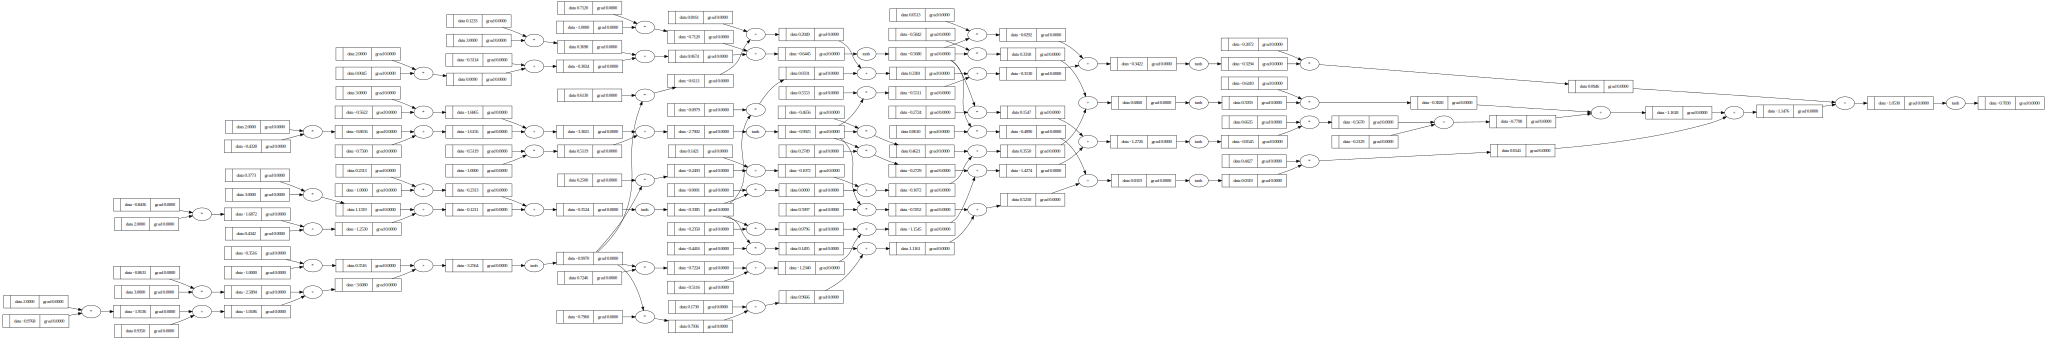

In [181]:
draw_dot(n(x))

The MLP (Multi-Layer Perceptron) class represents a simple neural network built using fully connected layers. This implementation is broken down into hierarchical components: Neuron, Layer, and MLP. Here’s a detailed breakdown of the MLP class and how it works.

1. What is MLP?

A Multi-Layer Perceptron is a type of neural network where neurons are arranged in layers, and each neuron in one layer is connected to all neurons in the next layer (fully connected). It consists of:

	•	Input layer: Takes input features.
	•	Hidden layers: Intermediate computation layers.
	•	Output layer: Produces final predictions.

The MLP class organizes these components, using the Layer and Neuron classes to build the network.

2. Components of the MLP Class

Constructor (__init__)

def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

	•	Purpose: Initializes the layers of the network.
	•	Parameters:
	•	nin: Number of input features.
	•	nouts: A list specifying the number of neurons in each layer (e.g., [5, 10, 1] means 2 layers: one with 5 neurons and the other with 10 neurons, and a single output neuron).
	•	Steps:
	1.	Combines nin and nouts to form a list sz representing the number of neurons in each layer (including input size).
	•	Example: If nin=3 and nouts=[4, 2], then sz = [3, 4, 2].
	2.	Creates a list of Layer objects, where each layer connects sz[i] input neurons to sz[i+1] output neurons.

Forward Pass (__call__)

def __call__(self, x):
    for layer in self.layers:
        x = layer(x)
    return x

	•	Purpose: Defines how input data flows through the network.
	•	Parameters:
	•	x: Input to the network (e.g., a list of values).
	•	Process:
	1.	Passes the input x through each layer in self.layers sequentially.
	2.	At each step, the output of one layer becomes the input for the next layer.
	3.	The final output is returned as the network’s prediction.

Parameters (parameters)

def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

	•	Purpose: Collects all the trainable parameters (weights and biases) of the network.
	•	Process:
	1.	Iterates through all Layer objects in self.layers.
	2.	Calls the parameters() method of each layer, which collects the parameters of all neurons in that layer.
	3.	Returns a flattened list of all parameters from all layers.

3. How Does MLP Work?

The MLP class leverages the Layer and Neuron classes:

Neuron

A single computational unit that:

	1.	Computes the weighted sum of its inputs: ￼.
	2.	Applies an activation function (e.g., tanh).

Layer

	•	A collection of neurons.
	•	Takes inputs, processes them through all neurons, and outputs a list of results.

MLP

	•	Combines multiple Layer objects to form a deep network.
	•	Passes input sequentially through all layers to compute the final output.

4. Example Workflow

Step 1: Initialize the MLP

mlp = MLP(3, [4, 2])

	•	Input size: 3 features.
	•	Two layers:
	1.	First layer: 3 inputs → 4 neurons.
	2.	Second layer: 4 inputs → 2 neurons.

Step 2: Forward Pass

output = mlp([0.5, -1.2, 0.8])

	•	Input [0.5, -1.2, 0.8] passes through the first layer.
	•	Output of the first layer becomes input to the second layer.
	•	Final output is a list with 2 values (since the second layer has 2 neurons).

Step 3: Get Parameters

params = mlp.parameters()

	•	Returns a list of all trainable parameters (weights and biases) from every neuron in the network.

5. Visualization of the Network

Given MLP(3, [4, 2]), the network structure is:

Input (3) → Layer (4 Neurons) → Layer (2 Neurons) → Output

Each layer has fully connected neurons:

	•	Layer 1:
	•	4 neurons, each with 3 weights and 1 bias.
	•	Layer 2:
	•	2 neurons, each with 4 weights and 1 bias.

6. Key Points

	•	Scalability: The design allows easy extension by adding more layers or neurons.
	•	Flexibility: By using classes, you can modify activation functions, architectures, or parameter initialization.
	•	Parameters: The parameters() method ensures all weights and biases are easily accessible for training.

In [182]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]

print(ypred)

[Value(data=-0.7829850390823434), Value(data=-0.603508549992834), Value(data=-0.6333003238162863), Value(data=-0.8606979275868899)]


In [183]:
loss = sum([(y - t)**2 for y,t in zip(ypred, ys)])

In [184]:
loss.backward()

In [185]:
n.layers[0].neurons[0].w[0].grad

0.009410004685272783

In [186]:
n.layers[0].neurons[0].w[0].data

-0.9767774712863679

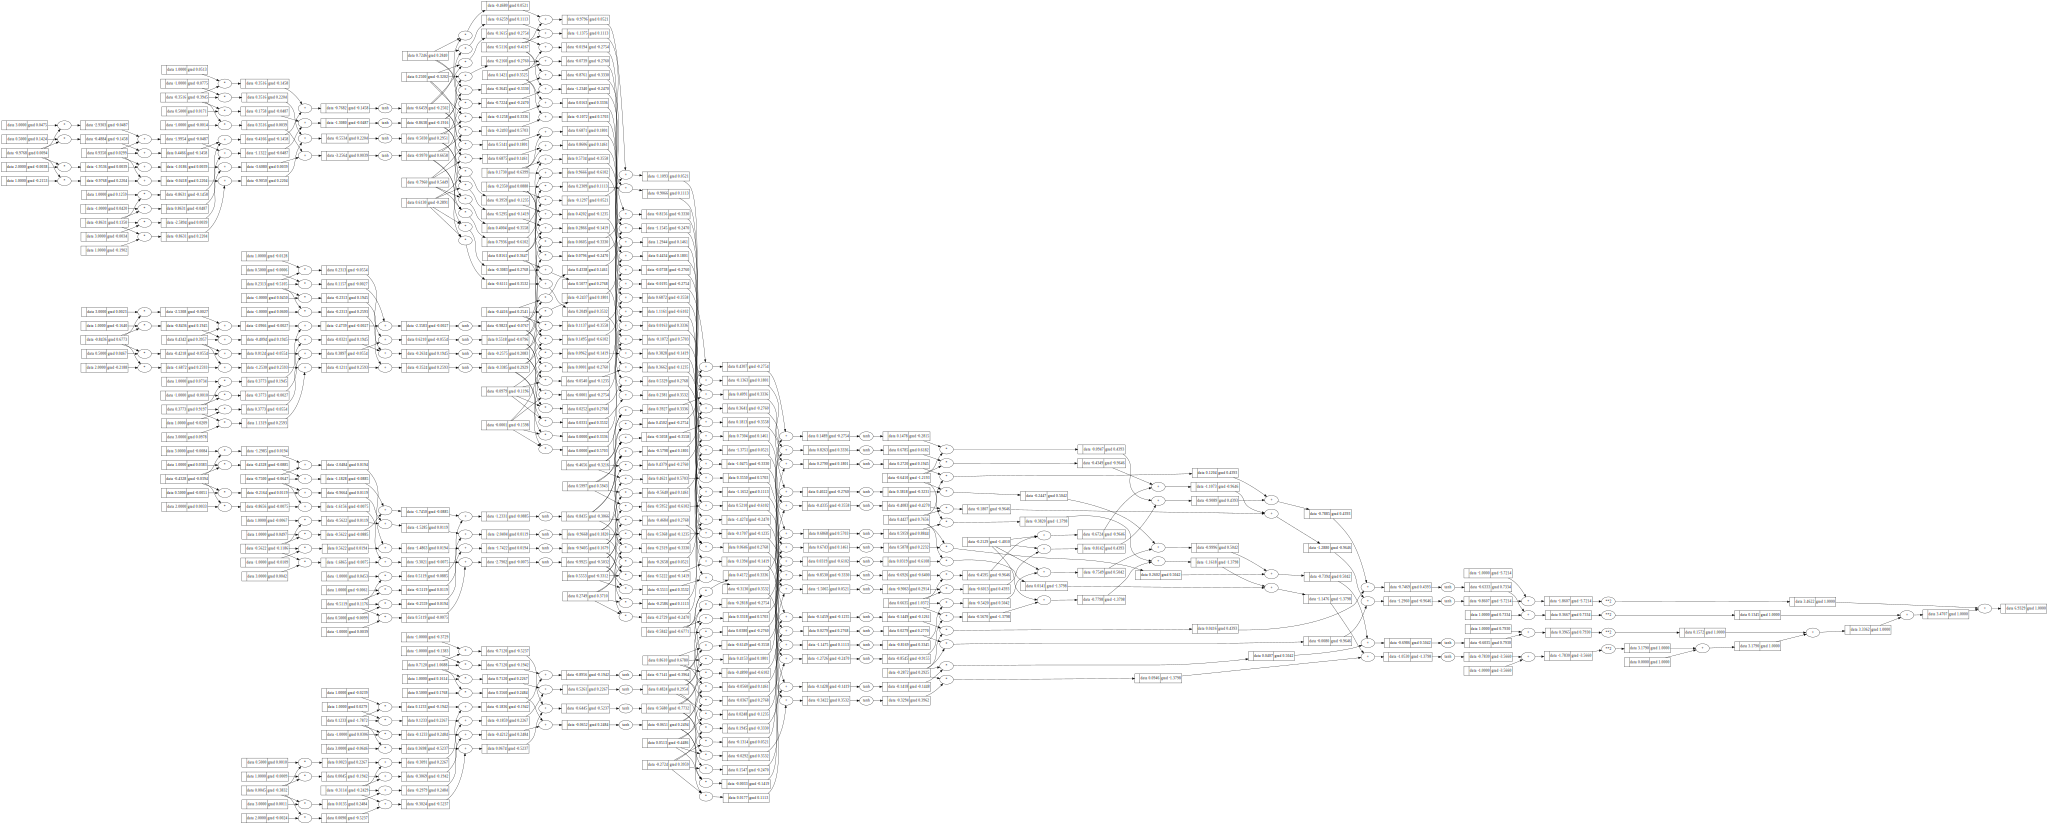

In [187]:
draw_dot(loss)

In [188]:
loss

Value(data=6.932906549759639)

In [191]:
loss

Value(data=6.932906549759639)

In [189]:
n.layers[0].neurons[0].w[0].data

-0.9767774712863679

In [194]:
loss.data

6.932906549759639

In [265]:
ypred = [n(x) for x in xs]
loss = sum([(y - t)**2 for y,t in zip(ypred, ys)])
loss

Value(data=0.1255099221341174)

In [266]:
loss.backward()

In [267]:
for p in n.parameters():
    p.data -= 0.01 * p.grad

In [268]:
ypred

[Value(data=0.8502146511077732),
 Value(data=-0.7868489402072331),
 Value(data=-0.8488329477670905),
 Value(data=0.8134807800257989)]

In [270]:
n.parameters()

[Value(data=-0.2596837984604943),
 Value(data=-0.9850378100840208),
 Value(data=1.2147867614113073),
 Value(data=1.4407456813108246),
 Value(data=-1.3780062162321043),
 Value(data=-0.21766635010646826),
 Value(data=1.1511439898009885),
 Value(data=0.2707947365743797),
 Value(data=-0.422329096228841),
 Value(data=-0.4396464781326539),
 Value(data=-0.6354474473466493),
 Value(data=-0.6944433513747529),
 Value(data=0.41290107827874284),
 Value(data=2.4840893785768228),
 Value(data=-0.9235863419370414),
 Value(data=0.030951275766510786),
 Value(data=0.5434993884498244),
 Value(data=-0.17166693102667346),
 Value(data=0.34871651059983233),
 Value(data=-0.246334015964272),
 Value(data=-0.5171969636312335),
 Value(data=0.6365364273579245),
 Value(data=0.555302349056333),
 Value(data=-0.506062791923615),
 Value(data=-0.2862664238326161),
 Value(data=0.0992253150347108),
 Value(data=-1.0387368613656376),
 Value(data=-0.7741388439466511),
 Value(data=0.5048479752826178),
 Value(data=0.20724338046

In [273]:
# Lets create gradient descent optimizer

for k in range(10):
    # Forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(y - t)**2 for y,t in zip(ypred, ys)])

    # Backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # Gradient descent (updating the parameters)

    for p in n.parameters():
        p.data -= 0.01 * p.grad

    print(k, loss.data)    

0 3.0261294475667572e-05
1 3.0259019336197875e-05
2 3.025674455498718e-05
3 3.025447013194761e-05
4 3.025219606699721e-05
5 3.024992236004767e-05
6 3.0247649011013582e-05
7 3.024537601981031e-05
8 3.024310338634984e-05
9 3.024083111054786e-05


In [272]:
ypred

[Value(data=0.9999782900704679),
 Value(data=-0.9931970691384302),
 Value(data=-0.9992705181476934),
 Value(data=0.9999741564519319)]